<a href="https://colab.research.google.com/github/mahesh-ml/MLBasics/blob/main/Optuna_optimizeCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import os
os.environ['PYTHONHASHSEED'] = '0'
import numpy as np
import tensorflow as tf
import random as python_random

np.random.seed(123)
python_random.seed(123)

tf.random.set_seed(1234)

In [26]:
!pip install optuna
import optuna

In [27]:
import itertools
from functools import partial
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.utils.np_utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense,Flatten,Conv2D , MaxPool2D
from tensorflow.keras.optimizers import Adam,RMSprop



In [28]:
data = pd.read_csv("/content/mnist.csv")

In [29]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [30]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['label'],axis=1),data['label'],test_size=0.1, random_state=0)
X_train.shape, X_test.shape

((37800, 784), (4200, 784))

Text(0, 0.5, 'number of images')

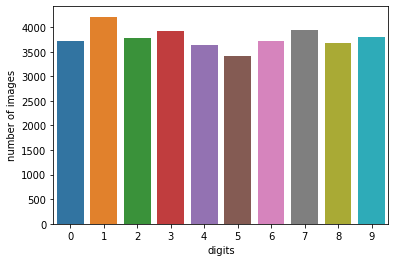

In [31]:
g = sns.countplot(x=y_train)
plt.xlabel("digits")
plt.ylabel('number of images')

In [32]:
#rescale and reshape
X_train= X_train / 255
X_test = X_test /255

#reshape
X_train=X_train.values.reshape(-1,28,28,1)
X_test=X_test.values.reshape(-1,28,28,1)


In [33]:
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)


y_train

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [34]:
path_best_model='cnn_model.h5'
best_accuracy=0

In [35]:
#objective function
def objective(trial):
  model= Sequential()
  num_conv_layers= trial.suggest_int('num_conv_layers',1,3)

  for i in range(num_conv_layers):
    model.add(Conv2D(
                     filters=trial.suggest_categorical('filters',[16,32,64]),
                     kernel_size=trial.suggest_categorical('kernel_size',[3,5]),
                     strides=trial.suggest_categorical('strides',[1,2]),
                     activation= trial.suggest_categorical('activation',['relu','tanh']), padding='same'
              
              ))
    model.add(MaxPool2D(pool_size=2, strides=2))

    model.add(Flatten())

    num_dense_layers = trial.suggest_int('num_dense_layers', 1, 3)

    for i in range(num_dense_layers):
        model.add(Dense(
             units = trial.suggest_int('units', 5,512),
             activation = trial.suggest_categorical('activation',['relu','tanh'])
        ))
    model.add(Dense(10,activation='softmax'))

    optimizer_name = trial.suggest_categorical('optimizer_name',['Adam','RMRProp'])

    if optimizer_name == 'Adam':
       optimizer = Adam(lr=trial.suggest_float('learning_rate',1e-6, 1e-2))
    else:
       optimizer = RMSprop(lr=trial.suggest_float('learning_rate',1e-6, 1e-2), 
                           momentum = trial.suggest_float('momentum',0.1,0.9))
       
    #compile model
  
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    #train model
    history = model.fit(x=X_train, 
                        y = y_train, 
                        epochs=3, 
                        batch_size=128,
                        validation_split=0.1)

    #accuracy
    accuracy= history.history['val_accuracy'][-1]

    global best_accuracy

    if accuracy > best_accuracy:
        model.save(path_best_model)
        best_accuracy = accuracy

    del model

    return accuracy

In [36]:
study_name='cnn_study'
storage_name="sqlite:///{}.db".format(study_name)

In [37]:
study = optuna.create_study(
    direction='maximize',
    study_name=study_name,
    storage= storage_name,
    load_if_exists=True

)

study.optimize(objective, n_trials=30)

[I 2021-11-10 22:06:18,127] Using an existing study with name 'cnn_study' instead of creating a new one.
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



Epoch 1/3
266/266 [==============================] - 4s 13ms/step - loss: 1.1996 - accuracy: 0.6572 - val_loss: 0.2282 - val_accuracy: 0.9304
Epoch 2/3
266/266 [==============================] - 3s 11ms/step - loss: 0.1776 - accuracy: 0.9491 - val_loss: 0.2085 - val_accuracy: 0.9426
Epoch 3/3
266/266 [==============================] - 3s 11ms/step - loss: 0.1245 - accuracy: 0.9647 - val_loss: 0.2172 - val_accuracy: 0.9481


[I 2021-11-10 22:06:31,124] Trial 30 finished with value: 0.9481481313705444 and parameters: {'num_conv_layers': 1, 'filters': 32, 'kernel_size': 5, 'strides': 1, 'activation': 'tanh', 'num_dense_layers': 2, 'units': 506, 'optimizer_name': 'RMRProp', 'learning_rate': 0.002769725063768323, 'momentum': 0.5524715000083009}. Best is trial 30 with value: 0.9481481313705444.
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



Epoch 1/3
266/266 [==============================] - 2s 7ms/step - loss: 0.7160 - accuracy: 0.8164 - val_loss: 0.3389 - val_accuracy: 0.9053
Epoch 2/3
266/266 [==============================] - 2s 6ms/step - loss: 0.2633 - accuracy: 0.9303 - val_loss: 0.2405 - val_accuracy: 0.9347
Epoch 3/3
266/266 [==============================] - 2s 6ms/step - loss: 0.2070 - accuracy: 0.9438 - val_loss: 0.2198 - val_accuracy: 0.9405


[I 2021-11-10 22:06:37,205] Trial 31 finished with value: 0.9404761791229248 and parameters: {'num_conv_layers': 1, 'filters': 32, 'kernel_size': 3, 'strides': 2, 'activation': 'tanh', 'num_dense_layers': 2, 'units': 6, 'optimizer_name': 'RMRProp', 'learning_rate': 0.0029109256056534367, 'momentum': 0.5694703261605986}. Best is trial 30 with value: 0.9481481313705444.
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



Epoch 1/3
266/266 [==============================] - 3s 8ms/step - loss: 0.3542 - accuracy: 0.8992 - val_loss: 0.2388 - val_accuracy: 0.9312
Epoch 2/3
266/266 [==============================] - 2s 7ms/step - loss: 0.1473 - accuracy: 0.9563 - val_loss: 0.1541 - val_accuracy: 0.9553
Epoch 3/3
266/266 [==============================] - 2s 7ms/step - loss: 0.1178 - accuracy: 0.9654 - val_loss: 0.1468 - val_accuracy: 0.9624


[I 2021-11-10 22:06:44,085] Trial 32 finished with value: 0.9624338746070862 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 3, 'strides': 2, 'activation': 'tanh', 'num_dense_layers': 2, 'units': 483, 'optimizer_name': 'RMRProp', 'learning_rate': 0.002831168767480192, 'momentum': 0.517012269177247}. Best is trial 32 with value: 0.9624338746070862.
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



Epoch 1/3
266/266 [==============================] - 2s 7ms/step - loss: 0.2570 - accuracy: 0.9203 - val_loss: 0.1390 - val_accuracy: 0.9556
Epoch 2/3
266/266 [==============================] - 2s 6ms/step - loss: 0.1235 - accuracy: 0.9630 - val_loss: 0.1496 - val_accuracy: 0.9598
Epoch 3/3
266/266 [==============================] - 2s 6ms/step - loss: 0.0924 - accuracy: 0.9721 - val_loss: 0.1342 - val_accuracy: 0.9643


[I 2021-11-10 22:06:50,256] Trial 33 finished with value: 0.9642857313156128 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 3, 'strides': 2, 'activation': 'tanh', 'num_dense_layers': 2, 'units': 267, 'optimizer_name': 'RMRProp', 'learning_rate': 0.0026660584335518617, 'momentum': 0.5620485699269737}. Best is trial 33 with value: 0.9642857313156128.
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



Epoch 1/3
266/266 [==============================] - 2s 7ms/step - loss: 0.2701 - accuracy: 0.9194 - val_loss: 0.1364 - val_accuracy: 0.9614
Epoch 2/3
266/266 [==============================] - 2s 6ms/step - loss: 0.1034 - accuracy: 0.9684 - val_loss: 0.1144 - val_accuracy: 0.9659
Epoch 3/3
266/266 [==============================] - 2s 6ms/step - loss: 0.0742 - accuracy: 0.9765 - val_loss: 0.1128 - val_accuracy: 0.9696


[I 2021-11-10 22:06:56,421] Trial 34 finished with value: 0.9695767164230347 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 3, 'strides': 2, 'activation': 'tanh', 'num_dense_layers': 2, 'units': 33, 'optimizer_name': 'RMRProp', 'learning_rate': 0.002790374237886413, 'momentum': 0.5534952567846437}. Best is trial 34 with value: 0.9695767164230347.
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



Epoch 1/3
266/266 [==============================] - 2s 6ms/step - loss: 0.2503 - accuracy: 0.9215 - val_loss: 0.1536 - val_accuracy: 0.9529
Epoch 2/3
266/266 [==============================] - 2s 6ms/step - loss: 0.1101 - accuracy: 0.9665 - val_loss: 0.1197 - val_accuracy: 0.9669
Epoch 3/3
266/266 [==============================] - 2s 6ms/step - loss: 0.0775 - accuracy: 0.9752 - val_loss: 0.1234 - val_accuracy: 0.9643


[I 2021-11-10 22:07:02,508] Trial 35 finished with value: 0.9642857313156128 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 3, 'strides': 2, 'activation': 'tanh', 'num_dense_layers': 2, 'units': 107, 'optimizer_name': 'RMRProp', 'learning_rate': 0.0028475382572120105, 'momentum': 0.5042083370338958}. Best is trial 34 with value: 0.9695767164230347.
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



Epoch 1/3
266/266 [==============================] - 2s 6ms/step - loss: 0.2713 - accuracy: 0.9166 - val_loss: 0.1415 - val_accuracy: 0.9574
Epoch 2/3
266/266 [==============================] - 2s 6ms/step - loss: 0.1041 - accuracy: 0.9681 - val_loss: 0.1215 - val_accuracy: 0.9664
Epoch 3/3
266/266 [==============================] - 2s 6ms/step - loss: 0.0740 - accuracy: 0.9772 - val_loss: 0.0891 - val_accuracy: 0.9741


[I 2021-11-10 22:07:08,402] Trial 36 finished with value: 0.9740740656852722 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 3, 'strides': 2, 'activation': 'tanh', 'num_dense_layers': 2, 'units': 42, 'optimizer_name': 'RMRProp', 'learning_rate': 0.002878983904416791, 'momentum': 0.4781051050947992}. Best is trial 36 with value: 0.9740740656852722.
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



Epoch 1/3
266/266 [==============================] - 2s 7ms/step - loss: 0.2779 - accuracy: 0.9143 - val_loss: 0.1372 - val_accuracy: 0.9595
Epoch 2/3
266/266 [==============================] - 2s 6ms/step - loss: 0.1093 - accuracy: 0.9670 - val_loss: 0.1414 - val_accuracy: 0.9587
Epoch 3/3
266/266 [==============================] - 2s 6ms/step - loss: 0.0782 - accuracy: 0.9749 - val_loss: 0.1106 - val_accuracy: 0.9693


[I 2021-11-10 22:07:14,336] Trial 37 finished with value: 0.9693121910095215 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 3, 'strides': 2, 'activation': 'tanh', 'num_dense_layers': 2, 'units': 48, 'optimizer_name': 'RMRProp', 'learning_rate': 0.0037509134972159995, 'momentum': 0.4353231045088961}. Best is trial 36 with value: 0.9740740656852722.
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



Epoch 1/3
266/266 [==============================] - 2s 6ms/step - loss: 0.2617 - accuracy: 0.9202 - val_loss: 0.1620 - val_accuracy: 0.9495
Epoch 2/3
266/266 [==============================] - 2s 6ms/step - loss: 0.1054 - accuracy: 0.9677 - val_loss: 0.1181 - val_accuracy: 0.9661
Epoch 3/3
266/266 [==============================] - 2s 6ms/step - loss: 0.0775 - accuracy: 0.9768 - val_loss: 0.1040 - val_accuracy: 0.9701


[I 2021-11-10 22:07:20,176] Trial 38 finished with value: 0.9701058268547058 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 3, 'strides': 2, 'activation': 'tanh', 'num_dense_layers': 2, 'units': 40, 'optimizer_name': 'RMRProp', 'learning_rate': 0.0049101823182365004, 'momentum': 0.42197637730897386}. Best is trial 36 with value: 0.9740740656852722.
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



Epoch 1/3
266/266 [==============================] - 2s 7ms/step - loss: 0.2552 - accuracy: 0.9200 - val_loss: 0.1352 - val_accuracy: 0.9569
Epoch 2/3
266/266 [==============================] - 2s 6ms/step - loss: 0.1021 - accuracy: 0.9685 - val_loss: 0.1099 - val_accuracy: 0.9680
Epoch 3/3
266/266 [==============================] - 2s 6ms/step - loss: 0.0753 - accuracy: 0.9767 - val_loss: 0.1055 - val_accuracy: 0.9717


[I 2021-11-10 22:07:26,283] Trial 39 finished with value: 0.9716930985450745 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 3, 'strides': 2, 'activation': 'tanh', 'num_dense_layers': 2, 'units': 42, 'optimizer_name': 'RMRProp', 'learning_rate': 0.004974008184944838, 'momentum': 0.42347625966505686}. Best is trial 36 with value: 0.9740740656852722.
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



Epoch 1/3
266/266 [==============================] - 2s 7ms/step - loss: 0.2678 - accuracy: 0.9178 - val_loss: 0.1461 - val_accuracy: 0.9579
Epoch 2/3
266/266 [==============================] - 2s 6ms/step - loss: 0.1065 - accuracy: 0.9665 - val_loss: 0.1211 - val_accuracy: 0.9664
Epoch 3/3
266/266 [==============================] - 2s 6ms/step - loss: 0.0746 - accuracy: 0.9765 - val_loss: 0.1264 - val_accuracy: 0.9638


[I 2021-11-10 22:07:32,119] Trial 40 finished with value: 0.9637566208839417 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 3, 'strides': 2, 'activation': 'tanh', 'num_dense_layers': 2, 'units': 41, 'optimizer_name': 'RMRProp', 'learning_rate': 0.005171111982228654, 'momentum': 0.2996668220390358}. Best is trial 36 with value: 0.9740740656852722.
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



Epoch 1/3
266/266 [==============================] - 2s 6ms/step - loss: 0.2543 - accuracy: 0.9207 - val_loss: 0.1549 - val_accuracy: 0.9532
Epoch 2/3
266/266 [==============================] - 2s 6ms/step - loss: 0.1039 - accuracy: 0.9693 - val_loss: 0.1028 - val_accuracy: 0.9709
Epoch 3/3
266/266 [==============================] - 1s 6ms/step - loss: 0.0759 - accuracy: 0.9762 - val_loss: 0.1034 - val_accuracy: 0.9704


[I 2021-11-10 22:07:37,910] Trial 41 finished with value: 0.970370352268219 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 3, 'strides': 2, 'activation': 'tanh', 'num_dense_layers': 2, 'units': 49, 'optimizer_name': 'RMRProp', 'learning_rate': 0.0058720343046826514, 'momentum': 0.43495111214055926}. Best is trial 36 with value: 0.9740740656852722.
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



Epoch 1/3
266/266 [==============================] - 2s 6ms/step - loss: 0.2401 - accuracy: 0.9249 - val_loss: 0.1444 - val_accuracy: 0.9590
Epoch 2/3
266/266 [==============================] - 2s 6ms/step - loss: 0.1092 - accuracy: 0.9670 - val_loss: 0.1011 - val_accuracy: 0.9735
Epoch 3/3
266/266 [==============================] - 2s 6ms/step - loss: 0.0764 - accuracy: 0.9764 - val_loss: 0.1235 - val_accuracy: 0.9683


[I 2021-11-10 22:07:43,996] Trial 42 finished with value: 0.9682539701461792 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 3, 'strides': 2, 'activation': 'tanh', 'num_dense_layers': 2, 'units': 60, 'optimizer_name': 'RMRProp', 'learning_rate': 0.005708231958534165, 'momentum': 0.4399360290142979}. Best is trial 36 with value: 0.9740740656852722.
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



Epoch 1/3
266/266 [==============================] - 3s 7ms/step - loss: 0.2640 - accuracy: 0.9160 - val_loss: 0.1988 - val_accuracy: 0.9376
Epoch 2/3
266/266 [==============================] - 2s 6ms/step - loss: 0.1087 - accuracy: 0.9668 - val_loss: 0.1255 - val_accuracy: 0.9648
Epoch 3/3
266/266 [==============================] - 2s 6ms/step - loss: 0.0744 - accuracy: 0.9769 - val_loss: 0.1168 - val_accuracy: 0.9672


[I 2021-11-10 22:07:50,580] Trial 43 finished with value: 0.9671957492828369 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 3, 'strides': 2, 'activation': 'tanh', 'num_dense_layers': 2, 'units': 83, 'optimizer_name': 'RMRProp', 'learning_rate': 0.005890516914829362, 'momentum': 0.3586779119712424}. Best is trial 36 with value: 0.9740740656852722.
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



Epoch 1/3
266/266 [==============================] - 2s 7ms/step - loss: 0.3769 - accuracy: 0.8882 - val_loss: 0.1795 - val_accuracy: 0.9444
Epoch 2/3
266/266 [==============================] - 2s 6ms/step - loss: 0.1326 - accuracy: 0.9605 - val_loss: 0.1295 - val_accuracy: 0.9646
Epoch 3/3
266/266 [==============================] - 2s 6ms/step - loss: 0.0915 - accuracy: 0.9728 - val_loss: 0.1399 - val_accuracy: 0.9635


[I 2021-11-10 22:07:56,671] Trial 44 finished with value: 0.9634920358657837 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 3, 'strides': 2, 'activation': 'tanh', 'num_dense_layers': 2, 'units': 158, 'optimizer_name': 'RMRProp', 'learning_rate': 0.006193931539722546, 'momentum': 0.2698066688892512}. Best is trial 36 with value: 0.9740740656852722.
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



Epoch 1/3
266/266 [==============================] - 2s 7ms/step - loss: 0.2586 - accuracy: 0.9202 - val_loss: 0.1581 - val_accuracy: 0.9516
Epoch 2/3
266/266 [==============================] - 2s 6ms/step - loss: 0.1069 - accuracy: 0.9675 - val_loss: 0.1312 - val_accuracy: 0.9614
Epoch 3/3
266/266 [==============================] - 2s 6ms/step - loss: 0.0821 - accuracy: 0.9745 - val_loss: 0.1351 - val_accuracy: 0.9651


[I 2021-11-10 22:08:02,760] Trial 45 finished with value: 0.9650793671607971 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 3, 'strides': 2, 'activation': 'tanh', 'num_dense_layers': 2, 'units': 30, 'optimizer_name': 'RMRProp', 'learning_rate': 0.005018113405321988, 'momentum': 0.4651331316771104}. Best is trial 36 with value: 0.9740740656852722.
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



Epoch 1/3
266/266 [==============================] - 2s 7ms/step - loss: 0.3405 - accuracy: 0.8955 - val_loss: 0.1874 - val_accuracy: 0.9455
Epoch 2/3
266/266 [==============================] - 1s 6ms/step - loss: 0.1207 - accuracy: 0.9633 - val_loss: 0.1235 - val_accuracy: 0.9640
Epoch 3/3
266/266 [==============================] - 2s 6ms/step - loss: 0.0889 - accuracy: 0.9725 - val_loss: 0.1267 - val_accuracy: 0.9677


[I 2021-11-10 22:08:08,623] Trial 46 finished with value: 0.9677248597145081 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 3, 'strides': 2, 'activation': 'tanh', 'num_dense_layers': 2, 'units': 83, 'optimizer_name': 'RMRProp', 'learning_rate': 0.0077631221122942155, 'momentum': 0.4113637037258866}. Best is trial 36 with value: 0.9740740656852722.
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



Epoch 1/3
266/266 [==============================] - 2s 7ms/step - loss: 0.4218 - accuracy: 0.8747 - val_loss: 0.1700 - val_accuracy: 0.9503
Epoch 2/3
266/266 [==============================] - 2s 6ms/step - loss: 0.1497 - accuracy: 0.9577 - val_loss: 0.1647 - val_accuracy: 0.9579
Epoch 3/3
266/266 [==============================] - 2s 6ms/step - loss: 0.1173 - accuracy: 0.9678 - val_loss: 0.1365 - val_accuracy: 0.9616


[I 2021-11-10 22:08:14,872] Trial 47 finished with value: 0.9616402387619019 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 3, 'strides': 2, 'activation': 'tanh', 'num_dense_layers': 3, 'units': 132, 'optimizer_name': 'RMRProp', 'learning_rate': 0.004765927413522573, 'momentum': 0.6149413285262699}. Best is trial 36 with value: 0.9740740656852722.
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



Epoch 1/3
266/266 [==============================] - 2s 6ms/step - loss: 0.3852 - accuracy: 0.8853 - val_loss: 0.2081 - val_accuracy: 0.9415
Epoch 2/3
266/266 [==============================] - 2s 6ms/step - loss: 0.1672 - accuracy: 0.9502 - val_loss: 0.1663 - val_accuracy: 0.9534
Epoch 3/3
266/266 [==============================] - 2s 6ms/step - loss: 0.1387 - accuracy: 0.9591 - val_loss: 0.1729 - val_accuracy: 0.9519


[I 2021-11-10 22:08:20,980] Trial 48 finished with value: 0.9518518447875977 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 3, 'strides': 2, 'activation': 'tanh', 'num_dense_layers': 2, 'units': 11, 'optimizer_name': 'RMRProp', 'learning_rate': 0.009712275940567994, 'momentum': 0.3874316701859814}. Best is trial 36 with value: 0.9740740656852722.
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



Epoch 1/3
266/266 [==============================] - 2s 6ms/step - loss: 0.2832 - accuracy: 0.9122 - val_loss: 0.1520 - val_accuracy: 0.9569
Epoch 2/3
266/266 [==============================] - 2s 6ms/step - loss: 0.1122 - accuracy: 0.9656 - val_loss: 0.1352 - val_accuracy: 0.9598
Epoch 3/3
266/266 [==============================] - 2s 6ms/step - loss: 0.0818 - accuracy: 0.9744 - val_loss: 0.1209 - val_accuracy: 0.9664


[I 2021-11-10 22:08:26,811] Trial 49 finished with value: 0.9664021134376526 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 3, 'strides': 2, 'activation': 'tanh', 'num_dense_layers': 2, 'units': 67, 'optimizer_name': 'RMRProp', 'learning_rate': 0.003804346824717854, 'momentum': 0.21264315137419484}. Best is trial 36 with value: 0.9740740656852722.
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



Epoch 1/3
266/266 [==============================] - 2s 7ms/step - loss: 0.3492 - accuracy: 0.8885 - val_loss: 0.1482 - val_accuracy: 0.9561
Epoch 2/3
266/266 [==============================] - 2s 6ms/step - loss: 0.1404 - accuracy: 0.9604 - val_loss: 0.1632 - val_accuracy: 0.9571
Epoch 3/3
266/266 [==============================] - 2s 6ms/step - loss: 0.1169 - accuracy: 0.9684 - val_loss: 0.1964 - val_accuracy: 0.9556


[I 2021-11-10 22:08:33,025] Trial 50 finished with value: 0.9555555582046509 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 3, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 3, 'units': 127, 'optimizer_name': 'RMRProp', 'learning_rate': 0.007107781301421246, 'momentum': 0.5323898651047789}. Best is trial 36 with value: 0.9740740656852722.
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



Epoch 1/3
266/266 [==============================] - 2s 7ms/step - loss: 0.2434 - accuracy: 0.9265 - val_loss: 0.1305 - val_accuracy: 0.9648
Epoch 2/3
266/266 [==============================] - 2s 6ms/step - loss: 0.1029 - accuracy: 0.9693 - val_loss: 0.1107 - val_accuracy: 0.9675
Epoch 3/3
266/266 [==============================] - 2s 6ms/step - loss: 0.0738 - accuracy: 0.9767 - val_loss: 0.1333 - val_accuracy: 0.9577


[I 2021-11-10 22:08:38,964] Trial 51 finished with value: 0.9576719403266907 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 3, 'strides': 2, 'activation': 'tanh', 'num_dense_layers': 2, 'units': 49, 'optimizer_name': 'RMRProp', 'learning_rate': 0.0034689971688921456, 'momentum': 0.4376904485760799}. Best is trial 36 with value: 0.9740740656852722.
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



Epoch 1/3
266/266 [==============================] - 2s 7ms/step - loss: 0.2636 - accuracy: 0.9232 - val_loss: 0.1501 - val_accuracy: 0.9556
Epoch 2/3
266/266 [==============================] - 2s 6ms/step - loss: 0.1106 - accuracy: 0.9660 - val_loss: 0.1281 - val_accuracy: 0.9659
Epoch 3/3
266/266 [==============================] - 2s 6ms/step - loss: 0.0827 - accuracy: 0.9745 - val_loss: 0.1296 - val_accuracy: 0.9624


[I 2021-11-10 22:08:45,106] Trial 52 finished with value: 0.9624338746070862 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 3, 'strides': 2, 'activation': 'tanh', 'num_dense_layers': 2, 'units': 27, 'optimizer_name': 'RMRProp', 'learning_rate': 0.0038725692690113377, 'momentum': 0.47263399105266113}. Best is trial 36 with value: 0.9740740656852722.
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



Epoch 1/3
266/266 [==============================] - 2s 7ms/step - loss: 0.2522 - accuracy: 0.9218 - val_loss: 0.1572 - val_accuracy: 0.9574
Epoch 2/3
266/266 [==============================] - 2s 6ms/step - loss: 0.1044 - accuracy: 0.9680 - val_loss: 0.1230 - val_accuracy: 0.9653
Epoch 3/3
266/266 [==============================] - 1s 6ms/step - loss: 0.0744 - accuracy: 0.9773 - val_loss: 0.1088 - val_accuracy: 0.9701


[I 2021-11-10 22:08:51,198] Trial 53 finished with value: 0.9701058268547058 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 3, 'strides': 2, 'activation': 'tanh', 'num_dense_layers': 2, 'units': 79, 'optimizer_name': 'RMRProp', 'learning_rate': 0.004749540602979373, 'momentum': 0.3403936890815702}. Best is trial 36 with value: 0.9740740656852722.
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



Epoch 1/3
266/266 [==============================] - 2s 7ms/step - loss: 0.4099 - accuracy: 0.8889 - val_loss: 0.2269 - val_accuracy: 0.9341
Epoch 2/3
266/266 [==============================] - 2s 6ms/step - loss: 0.1314 - accuracy: 0.9609 - val_loss: 0.1175 - val_accuracy: 0.9669
Epoch 3/3
266/266 [==============================] - 2s 6ms/step - loss: 0.0943 - accuracy: 0.9723 - val_loss: 0.1214 - val_accuracy: 0.9690


[I 2021-11-10 22:08:57,195] Trial 54 finished with value: 0.9690476059913635 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 3, 'strides': 2, 'activation': 'tanh', 'num_dense_layers': 2, 'units': 193, 'optimizer_name': 'RMRProp', 'learning_rate': 0.005608223840162485, 'momentum': 0.3495341122191895}. Best is trial 36 with value: 0.9740740656852722.
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



Epoch 1/3
266/266 [==============================] - 2s 6ms/step - loss: 0.2780 - accuracy: 0.9139 - val_loss: 0.1527 - val_accuracy: 0.9553
Epoch 2/3
266/266 [==============================] - 2s 6ms/step - loss: 0.1058 - accuracy: 0.9664 - val_loss: 0.1202 - val_accuracy: 0.9638
Epoch 3/3
266/266 [==============================] - 2s 6ms/step - loss: 0.0693 - accuracy: 0.9775 - val_loss: 0.1047 - val_accuracy: 0.9685


[I 2021-11-10 22:09:02,974] Trial 55 finished with value: 0.9685184955596924 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 3, 'strides': 2, 'activation': 'tanh', 'num_dense_layers': 2, 'units': 80, 'optimizer_name': 'Adam', 'learning_rate': 0.004771527560163602}. Best is trial 36 with value: 0.9740740656852722.
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



Epoch 1/3
266/266 [==============================] - 3s 7ms/step - loss: 0.3083 - accuracy: 0.9059 - val_loss: 0.1582 - val_accuracy: 0.9526
Epoch 2/3
266/266 [==============================] - 2s 6ms/step - loss: 0.1197 - accuracy: 0.9643 - val_loss: 0.1301 - val_accuracy: 0.9643
Epoch 3/3
266/266 [==============================] - 2s 6ms/step - loss: 0.0810 - accuracy: 0.9750 - val_loss: 0.1090 - val_accuracy: 0.9680


[I 2021-11-10 22:09:09,433] Trial 56 finished with value: 0.967989444732666 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 3, 'strides': 2, 'activation': 'tanh', 'num_dense_layers': 2, 'units': 111, 'optimizer_name': 'RMRProp', 'learning_rate': 0.005989273640465403, 'momentum': 0.2692769141150309}. Best is trial 36 with value: 0.9740740656852722.
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



Epoch 1/3
266/266 [==============================] - 2s 7ms/step - loss: 0.4081 - accuracy: 0.8672 - val_loss: 0.1607 - val_accuracy: 0.9513
Epoch 2/3
266/266 [==============================] - 2s 6ms/step - loss: 0.1306 - accuracy: 0.9594 - val_loss: 0.1356 - val_accuracy: 0.9614
Epoch 3/3
266/266 [==============================] - 2s 6ms/step - loss: 0.0933 - accuracy: 0.9709 - val_loss: 0.1083 - val_accuracy: 0.9677


[I 2021-11-10 22:09:15,509] Trial 57 finished with value: 0.9677248597145081 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 3, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 29, 'optimizer_name': 'RMRProp', 'learning_rate': 0.0047135187730374135, 'momentum': 0.12104569287186734}. Best is trial 36 with value: 0.9740740656852722.
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



Epoch 1/3
266/266 [==============================] - 2s 7ms/step - loss: 0.2506 - accuracy: 0.9214 - val_loss: 0.1884 - val_accuracy: 0.9413
Epoch 2/3
266/266 [==============================] - 2s 6ms/step - loss: 0.1075 - accuracy: 0.9670 - val_loss: 0.1132 - val_accuracy: 0.9661
Epoch 3/3
266/266 [==============================] - 2s 6ms/step - loss: 0.0749 - accuracy: 0.9774 - val_loss: 0.1087 - val_accuracy: 0.9717


[I 2021-11-10 22:09:21,606] Trial 58 finished with value: 0.9716930985450745 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 3, 'strides': 2, 'activation': 'tanh', 'num_dense_layers': 2, 'units': 65, 'optimizer_name': 'RMRProp', 'learning_rate': 0.005325738799483061, 'momentum': 0.48539559949670874}. Best is trial 36 with value: 0.9740740656852722.
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



Epoch 1/3
266/266 [==============================] - 2s 6ms/step - loss: 0.2770 - accuracy: 0.9158 - val_loss: 0.1417 - val_accuracy: 0.9595
Epoch 2/3
266/266 [==============================] - 2s 6ms/step - loss: 0.0980 - accuracy: 0.9697 - val_loss: 0.1103 - val_accuracy: 0.9669
Epoch 3/3
266/266 [==============================] - 2s 6ms/step - loss: 0.0660 - accuracy: 0.9792 - val_loss: 0.0902 - val_accuracy: 0.9738


[I 2021-11-10 22:09:27,724] Trial 59 finished with value: 0.973809540271759 and parameters: {'num_conv_layers': 2, 'filters': 16, 'kernel_size': 3, 'strides': 2, 'activation': 'tanh', 'num_dense_layers': 2, 'units': 61, 'optimizer_name': 'Adam', 'learning_rate': 0.005330910713807278}. Best is trial 36 with value: 0.9740740656852722.


In [38]:
study.best_params


{'activation': 'tanh',
 'filters': 16,
 'kernel_size': 3,
 'learning_rate': 0.002878983904416791,
 'momentum': 0.4781051050947992,
 'num_conv_layers': 1,
 'num_dense_layers': 2,
 'optimizer_name': 'RMRProp',
 'strides': 2,
 'units': 42}

In [39]:
study.best_value

0.9740740656852722

Text(0, 0.5, 'Accuracy')

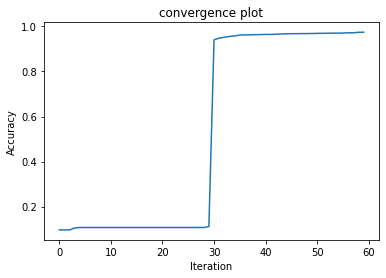

In [40]:
#analyze result


results = study.trials_dataframe()

results['value'].sort_values().reset_index(drop=True).plot()
plt.title('convergence plot')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

In [41]:
#Evaluate
model = load_model(path_best_model)

model.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 14, 14, 16)        160       
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 7, 7, 16)         0         
 g2D)                                                            
                                                                 
 flatten_36 (Flatten)        (None, 784)               0         
                                                                 
 dense_95 (Dense)            (None, 42)                32970     
                                                                 
 dense_96 (Dense)            (None, 42)                1806      
                                                                 
 dense_97 (Dense)            (None, 10)                430       
                                                     

In [42]:
results = model.evaluate(x=X_test, y = y_test)

132/132 [==============================] - 1s 4ms/step - loss: 0.0870 - accuracy: 0.9745


In [45]:
for name , value in zip(model.metrics_names,results):
  print(name, value)

loss 0.08697552233934402
accuracy 0.9745237827301025


In [46]:
#confuison matrix
y_pred = model.predict(X_test)
y_pred_classes= np.argmax(y_pred, axis=1)
y_true= np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)

cm


array([[413,   0,   1,   1,   0,   0,   4,   0,   2,   1],
       [  0, 470,   3,   0,   0,   0,   0,   0,   0,   0],
       [  1,   2, 401,   1,   0,   1,   1,   2,   0,   0],
       [  0,   0,   3, 408,   0,   4,   1,   5,   3,   2],
       [  1,   2,   1,   0, 422,   0,   2,   0,   0,   1],
       [  0,   0,   0,   3,   0, 371,   3,   0,   3,   2],
       [  0,   1,   2,   0,   1,   2, 406,   0,   0,   0],
       [  0,   3,   5,   2,   1,   0,   0, 458,   0,   0],
       [  0,   1,   3,   2,   0,   3,   3,   1, 370,   1],
       [  2,   1,   0,   3,  10,   1,   0,   3,   0, 374]])

Text(0.5, 13.421126458070283, 'Predicted label')

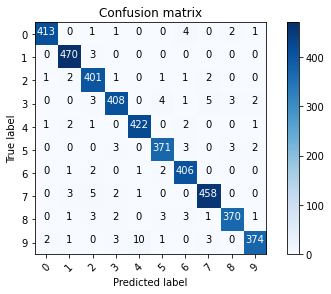

In [47]:
# let's make it more colourful
classes = 10

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(classes)
plt.xticks(tick_marks, range(classes), rotation=45)
plt.yticks(tick_marks, range(classes))

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > 100 else "black",
            )

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')